**Big Data Analytics**
Pandari Naga Veera Sainath CHUNDRU



# **Initiate and Configure Spark**

---


In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=5e7cf4da49716bfe60e09a6357f3fc93c55cca21caf97538dd6bd44d1d12ab79
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
pip install tabulate

In [ ]:
# linking with Spark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import avg, desc, col, sum
from pyspark.sql.functions import rank
from datetime import datetime

# linking with plot
import matplotlib.pyplot as plt
import pandas as pd


# **Load Unstructured Data and Convert it to Spark DF**

---


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import avg, desc
from pyspark.sql.functions import rank

from pyspark.sql.types import StructType, StructField, StringType
from google.colab import drive
drive.mount('/content/drive')
# Load the unstructrued data: (1) drag and drop data here or (2) use Google Drive

Mounted at /content/drive


In [ ]:
#CREATING A SESSION
spark = SparkSession.builder.appName("Analysis").getOrCreate()

In [ ]:
# Reading the unstructured data into dataframe
data_path = "/content/drive/My Drive/web.log"

data_df = spark.read.text(data_path)
data_df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+
|88.211.105.115 - - [04/Mar/2022:14:17:48] "POST /history/missions/ HTTP/2.0" 414 12456 Caution: System may require attention. Check logs for details.       |
|144.6.49.142 - - [02/Sep/2022:15:16:00] "POST /security/firewall/ HTTPS/1.0" 203 97126 Warning: Unusual behavior detected. Investigate further.             |
|231.70.64.145 - - [19/Jul/2022:01:31:31] "PUT /web-development/countdown/ HTTP/1.0" 201 33093 Informational message. No action required.                    |
|219.42.234.172 - - [08/Feb/2022:11:34:57] "PO

In [ ]:
from pyspark.sql.functions import regexp_extract

# Read the log file into a DataFrame
log_data = spark.read.text(data_path)

# Define a regular expression pattern to extract information from the log entries
log_pattern = r'(\S+) - - \[([^\]]+)\] "(\S+) (\S+) (\S+)" (\d+) (\S+) (.*)'

# Extract relevant information using regexp_extract
log_data = log_data.select(
    regexp_extract(log_data["value"], log_pattern, 1).alias("Host"),
    regexp_extract(log_data["value"], log_pattern, 2).alias("Timestamp"),
    regexp_extract(log_data["value"], log_pattern, 3).alias("HTTPMethod"),
    regexp_extract(log_data["value"], log_pattern, 4).alias("URL"),
    regexp_extract(log_data["value"], log_pattern, 5).alias("HTTPVersion"),
    regexp_extract(log_data["value"], log_pattern, 6).alias("HTTPStatusCode"),
    regexp_extract(log_data["value"], log_pattern, 7).alias("BytesInReply"),
    regexp_extract(log_data["value"], log_pattern, 8).alias("Message"))
# Display the transformed DataFrame
log_data.show(25, truncate=False)

+---------------+--------------------+----------+---------------------------------------+-----------+--------------+------------+--------------------------------------------------------------+
|Host           |Timestamp           |HTTPMethod|URL                                    |HTTPVersion|HTTPStatusCode|BytesInReply|Message                                                       |
+---------------+--------------------+----------+---------------------------------------+-----------+--------------+------------+--------------------------------------------------------------+
|88.211.105.115 |04/Mar/2022:14:17:48|POST      |/history/missions/                     |HTTP/2.0   |414           |12456       |Caution: System may require attention. Check logs for details.|
|144.6.49.142   |02/Sep/2022:15:16:00|POST      |/security/firewall/                    |HTTPS/1.0  |203           |97126       |Warning: Unusual behavior detected. Investigate further.      |
|231.70.64.145  |19/Jul/2022:01:31:

In [ ]:
#create a temporary view
log_data.createOrReplaceTempView("log_data_view")

+-----------+------------+
|       Date|RequestCount|
+-----------+------------+
|12/Apr/2023|        4404|
|30/Oct/2022|        4323|
|13/Apr/2023|        4416|
|21/Dec/2022|        4424|
|18/Jan/2023|        4348|
+-----------+------------+



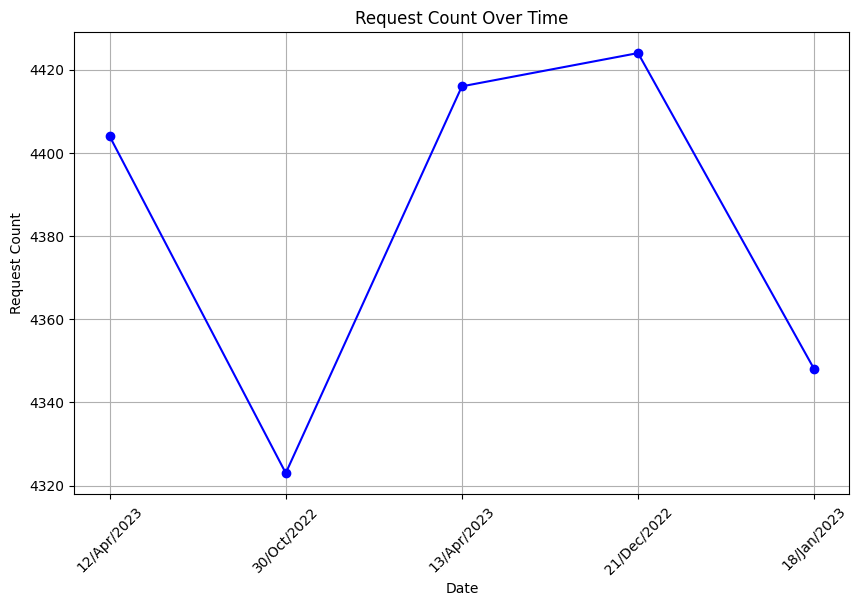

In [ ]:
sql_df = spark.sql("SELECT SUBSTRING(Timestamp, 1, 11) AS Date, COUNT(*) AS RequestCount FROM log_data_view GROUP BY Date LIMIT 5")
sql_df.show()
result_df = sql_df.toPandas()

# Plot a line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['RequestCount'], marker='o', linestyle='-', color='b')
plt.title('Request Count Over Time')
plt.xlabel('Date')
plt.ylabel('Request Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

+-------------+------------------+----+
|         Host|avg_bytes_in_reply|rank|
+-------------+------------------+----+
|34.162.74.219|           98573.0|   1|
|34.162.74.219|           98573.0|   1|
|116.76.146.27|           97019.5|   3|
+-------------+------------------+----+

None


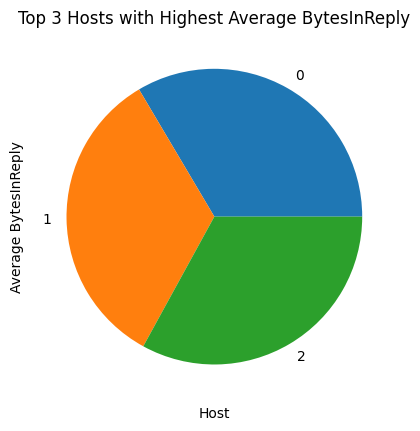

In [ ]:
overall_avg_request_count = spark.sql("SELECT AVG(request_count) FROM (SELECT COUNT(*) AS request_count FROM log_data_view GROUP BY Host)").collect()[0][0]

# Top 3 hosts with the highest average BytesInReply
query = f"""
WITH HostStats AS (
    SELECT
        Host,
        AVG(BytesInReply) OVER (PARTITION BY Host) AS avg_bytes_in_reply,
        COUNT(*) OVER (PARTITION BY Host) AS host_request_count
    FROM log_data_view
)
SELECT
    Host,
    avg_bytes_in_reply,
    RANK() OVER (ORDER BY avg_bytes_in_reply DESC) AS rank
FROM HostStats
WHERE host_request_count > {overall_avg_request_count}
ORDER BY rank ASC
LIMIT 3
"""

result = spark.sql(query)
print(result.show())

# Plotting the graph for the result
result_pd = result.toPandas()
result_pd.plot(kind="pie", x="Host", y="avg_bytes_in_reply", legend=False)
plt.title("Top 3 Hosts with Highest Average BytesInReply")
plt.xlabel("Host")
plt.ylabel("Average BytesInReply")
plt.show()

In [ ]:
# Build the SQL query for summary statistics
sql_query = f"""
    SELECT
        'HTTPStatusCode' AS column_name,
        MIN(HTTPStatusCode) AS min_value,
        PERCENTILE(HTTPStatusCode, 0.25) AS q1_value,
        PERCENTILE(HTTPStatusCode, 0.5) AS median_value,
        PERCENTILE(HTTPStatusCode, 0.75) AS q3_value,
        MAX(HTTPStatusCode) AS max_value,
        COUNT(HTTPStatusCode) AS count
    FROM log_data_view
    UNION
    SELECT
        'BytesInReply' AS column_name,
        MIN(BytesInReply) AS min_value,
        PERCENTILE(BytesInReply, 0.25) AS q1_value,
        PERCENTILE(BytesInReply, 0.5) AS median_value,
        PERCENTILE(BytesInReply, 0.75) AS q3_value,
        MAX(BytesInReply) AS max_value,
        COUNT(BytesInReply) AS count
    FROM log_data_view

"""

# Execute the SQL query
summary_df = spark.sql(sql_query)
summary_df.show()



+--------------+---------+--------+------------+--------+---------+------+
|   column_name|min_value|q1_value|median_value|q3_value|max_value| count|
+--------------+---------+--------+------------+--------+---------+------+
|HTTPStatusCode|      200|   203.0|       304.0|   414.0|      500|765138|
|  BytesInReply|     1000| 25772.0|     50464.5| 75249.0|    99999|765138|
+--------------+---------+--------+------------+--------+---------+------+



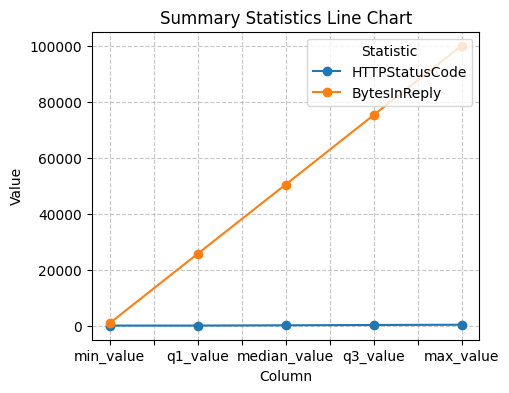

In [ ]:
# Assuming summary_df is your DataFrame containing the summary statistics
summary_pandas_df = summary_df.toPandas()

# Convert specific columns to numeric
numeric_columns = ['min_value', 'q1_value', 'median_value', 'q3_value', 'max_value']
summary_pandas_df[numeric_columns] = summary_pandas_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Create a line chart with reduced dimensions and a grid
ax = summary_pandas_df.set_index('column_name')[numeric_columns].T.plot(kind='line', marker='o', figsize=(5, 4))

# Add a grid to the background
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.title('Summary Statistics Line Chart')
plt.xlabel('Column')
plt.ylabel('Value')
plt.legend(title='Statistic', loc='upper right')
plt.show()

In [ ]:
sql_1 = """
SELECT HTTPVersion AS HTTPVersion, COUNT(*) AS count
FROM log_data_view
GROUP BY HTTPVersion
ORDER BY count DESC
"""
# Execute the second SQL query
result_df_1 = spark.sql(sql_1)
result_df_1.show()

+-----------+------+
|HTTPVersion| count|
+-----------+------+
|  HTTPS/1.0|255359|
|   HTTP/2.0|255182|
|   HTTP/1.0|254597|
+-----------+------+



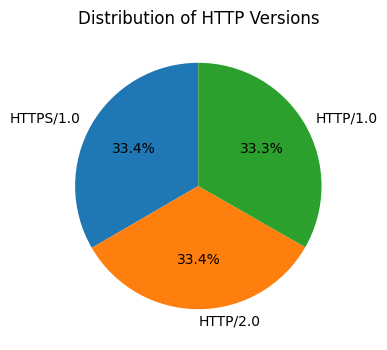

In [ ]:
http_versions = [row["HTTPVersion"] for row in result_df_1.collect()]
counts = [row["count"] for row in result_df_1.collect()]

# Creating a pie chart
plt.figure(figsize=(6, 4))
plt.pie(counts, labels=http_versions, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of HTTP Versions")
plt.show()

In [ ]:
# select the each unique value of bytes_in_reply after january 1, 2023.
# calculate the total count of occurre nces for each unique value of bytes in reply and distinct host for each bytes_in_reply
sql_query = """
    SELECT
        BytesInReply,
        COUNT(*) AS bytes_total_count,
        SUM(BytesInReply) AS total_bytes,

        COLLECT_LIST(DISTINCT Host) AS unique_source_Hosts
    FROM
        log_data_view
    WHERE
        timestamp > '2023-01-01 00:00:00'
    GROUP BY
        BytesInReply
    HAVING
        COUNT(*) > 22
"""
#Execute the SQL QUERY1
result1 = spark.sql(sql_query)
result1.show()

+------------+-----------------+-----------+--------------------+
|BytesInReply|bytes_total_count|total_bytes| unique_source_Hosts|
+------------+-----------------+-----------+--------------------+
|       13853|               25|   346325.0|[158.125.240.139,...|
|       18810|               23|   432630.0|[110.206.118.78, ...|
|       25193|               23|   579439.0|[91.145.63.126, 1...|
|        2660|               23|    61180.0|[182.248.71.232, ...|
|       32329|               23|   743567.0|[100.59.181.74, 2...|
|       36407|               23|   837361.0|[131.178.233.217,...|
|       37585|               24|   902040.0|[83.31.182.8, 32....|
|       38708|               24|   928992.0|[106.51.221.24, 2...|
|       43935|               23|  1010505.0|[150.100.200.67, ...|
|       46845|               26|  1217970.0|[173.119.231.156,...|
|       54662|               24|  1311888.0|[196.177.75.29, 1...|
|       58087|               23|  1336001.0|[165.187.70.190, ...|
|       60

<Axes: title={'center': 'Distribution of bytes in reply'}, xlabel='BytesInReply'>

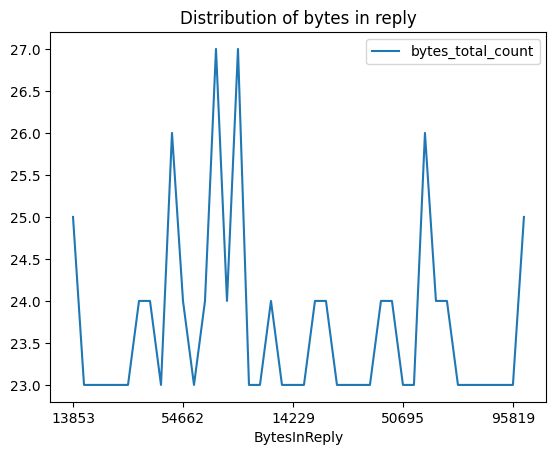

In [ ]:
#using pandas for data visualisation
pandas_df = result1.toPandas()

#plot a line chart using pandas and matplotlib
pandas_df.plot(x ='BytesInReply', y='bytes_total_count', kind = 'line', title ='Distribution of bytes in reply')


In [ ]:
#using subquery select the url with status code is 200
# calculate the count occurences of each url with inner subquery result and filter the results betweeen some ranges
sql_query1 = spark.sql("""
  SELECT
    URL,
    COUNT(*) AS url_count
  FROM
    (
      SELECT
        url
      FROM
        log_data_view
      WHERE
        HTTPStatusCode = 200
    ) subquery
  GROUP BY
    URL
  HAVING
    COUNT(*) BETWEEN 1850 AND 1900
""")
#Execute the SQL Query2
sql_query1.show()



+--------------------+---------+
|                 URL|url_count|
+--------------------+---------+
|  /shuttle/missions/|     1875|
|/software/cyberse...|     1878|
|/web-development/...|     1882|
|/security/technol...|     1876|
|/data-analysis/te...|     1868|
|     /images/launch/|     1860|
|/software/aws-cer...|     1877|
| /security/firewall/|     1897|
|/networking/techn...|     1859|
+--------------------+---------+



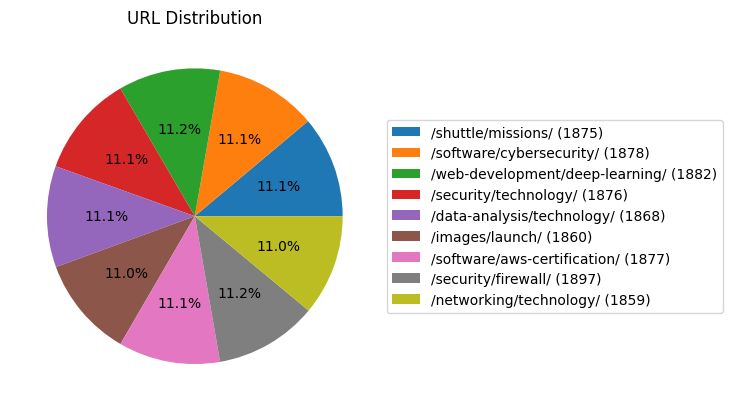

In [ ]:
#convert to toPandas for data visualisation
pandas_df1 = sql_query1.toPandas()

# Plot a pie chart using pandas and matplotlib
ax = pandas_df1.plot(y='url_count', kind='pie', autopct='%1.1f%%', legend=False, labels=None)

# Display 'URL' values on the right side
labels = [f"{url} ({count})" for url, count in zip(pandas_df1['URL'], pandas_df1['url_count'])]
ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('URL Distribution')
plt.ylabel('')  # Remove the y-axis label for a pie chart
plt.show()


# **Task 2 - Spark RDD**

---


In [ ]:
# Convert DataFrame to RDD
log_rdd = log_data.rdd


In [ ]:
# analysis 1 and result using RDD operators:

# Map the data to a structure of (HTTP version, Bytes in the reply)
map_data = log_rdd.map(lambda line: ((line.split()[4]), int(line.split()[8])))

# Reduce by key to find the sum of bytes for each (HTTP method)
sum_data = map_data.reduceByKey(lambda a, b: a + b)

# Displaying the  HTTP method, and sum of bytes
sum_data.collect()





[('"PUT', 50431138942), ('"GET', 50534774103), ('"POST', 50531539123)]

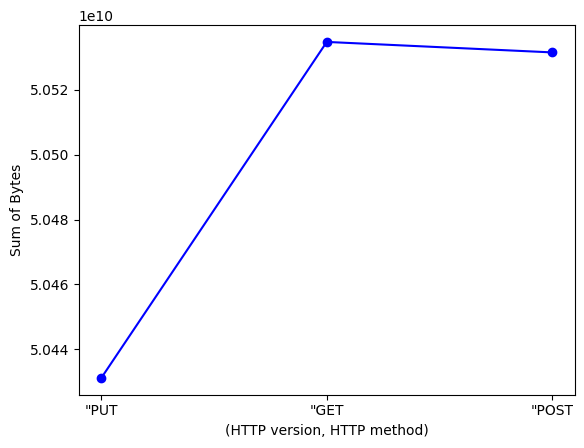

In [ ]:
import matplotlib.pyplot as plt

data = sum_data.collect()
versions_methods = [item[0] for item in data]
sum_bytes = [item[1] for item in data]

plt.plot(versions_methods, sum_bytes, marker='o', linestyle='-', color='b')
plt.xlabel('(HTTP version, HTTP method)')
plt.ylabel('Sum of Bytes')
plt.show()



In [ ]:
# analysis 1 and result using RDD operators:

# Assuming log_rdd is your RDD with the log entries
# Assuming each log entry is a string with the columns separated by space

# Extract HTTPStatusCode and BytesInReply from each log entry
host_bytes_rdd = log_rdd.map(lambda entry: (entry.split(" ")[0], entry.split(" ")[8]) if entry else None)

# Filter out rows where HTTPStatusCode or BytesInReply is not available
host_bytes_rdd = host_bytes_rdd.filter(lambda x: x is not None)

# Collect and print the last 10 rows
last_10_rows = host_bytes_rdd.takeOrdered(10, key=lambda x: x[0])  # Assuming you want to order by Host
for host, bytes_in_reply in last_10_rows:
    print(f"Host: {host}, BytesInReply: {bytes_in_reply}")

Host: 1.1.104.46, BytesInReply: 22792
Host: 1.1.108.121, BytesInReply: 20583
Host: 1.1.118.39, BytesInReply: 24629
Host: 1.1.119.183, BytesInReply: 19543
Host: 1.1.120.92, BytesInReply: 64102
Host: 1.1.126.167, BytesInReply: 10775
Host: 1.1.134.30, BytesInReply: 27817
Host: 1.1.134.82, BytesInReply: 79192
Host: 1.1.138.78, BytesInReply: 34617
Host: 1.1.153.25, BytesInReply: 15902


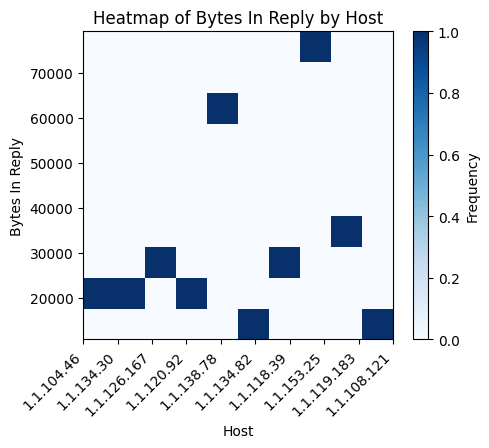

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming last_10_rows contains the data
hosts = [host for host, _ in last_10_rows]
bytes_in_reply = [int(bytes_in_reply) for _, bytes_in_reply in last_10_rows]

# Convert host labels to numeric indices
host_indices = np.arange(len(set(hosts)))

# Create a 2D histogram (heatmap)
plt.figure(figsize=(5, 4))
plt.hist2d(host_indices, bytes_in_reply, bins=(len(set(hosts)), 10), cmap='Blues')
plt.xlabel('Host')
plt.xticks(host_indices, set(hosts), rotation=45, ha='right')  # Use original host names as tick labels
plt.ylabel('Bytes In Reply')
plt.title('Heatmap of Bytes In Reply by Host')
plt.colorbar(label='Frequency')
plt.show()


In [ ]:
# analysis 2 and result using RDD operators:

import plotly.express as px
from datetime import datetime

# Extract the timestamp and host columns and filter rows between 29/Aug/2023 14:00:00 and 29/Aug/2023 20:00:00
filtered_entries = (
    log_rdd
    .map(lambda row: (row.split("[")[1].split("]")[0], row.split("- -")[0]) if "[" in row and "]" in row and "- -" in row else None)
    .filter(lambda x: x is not None and "29/Aug/2023" in x[0])
    .filter(lambda x: datetime.strptime(x[0], "%d/%b/%Y:%H:%M:%S") >= datetime(2023, 8, 29, 14, 10, 11) and datetime.strptime(x[0], "%d/%b/%Y:%H:%M:%S") <= datetime(2023, 8, 29, 14, 12, 8))
)

# Convert RDD data to a list of dictionaries
data_list = [{'Host': entry[1].strip(), 'Timestamp': entry[0]} for entry in filtered_entries.collect()]

# Print the filtered entries
for entry in data_list:
    print(f"Timestamp: {entry['Timestamp']}, Host: {entry['Host']}")

# Create and show the scatter plot with Plotly Express
fig = px.scatter(data_list, x='Timestamp', y='Host', title='Scatter Plot of Hosts and Timestamps')
fig.update_layout(xaxis=dict(tickangle=45, title='Timestamp'), yaxis=dict(title='Host'))
fig.update_layout(height=400, width=600)  # Adjust the height and width as needed
fig.show()



Timestamp: 29/Aug/2023:14:11:09, Host: 212.255.150.125
Timestamp: 29/Aug/2023:14:12:01, Host: 110.20.23.53
Timestamp: 29/Aug/2023:14:11:50, Host: 10.9.123.205
Timestamp: 29/Aug/2023:14:10:15, Host: 135.62.159.137
Timestamp: 29/Aug/2023:14:11:46, Host: 137.165.202.22


In [ ]:
# analysis 3 and result using RDD operators:

from tabulate import tabulate

# Assuming log_rdd is your RDD with log entries
# Assuming each log entry is a string with URL as the second part and HTTPStatusCode as the eighth part

# Extract URL and HTTPStatusCode from each log entry
url_status_rdd = log_rdd.map(lambda entry: (entry.split(" ")[5] if entry else None, entry.split(" ")[7] if entry else None))

# Filter out rows where URL or HTTPStatusCode is not available
url_status_rdd = url_status_rdd.filter(lambda x: x[0] is not None and x[1] is not None)

# Filter rows where HTTPStatusCode is between 200 and 400
filtered_entries = url_status_rdd.filter(lambda x: 200 <= int(x[1]) <= 400)

# Get distinct URLs along with HTTPStatusCode
distinct_urls_with_status = filtered_entries.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x).map(lambda x: x[0])

# Take the top 10 rows
top_10_results = distinct_urls_with_status.take(10)

# Display the top 10 results in a table
table_headers = ["Distinct URL", "HTTPStatusCode"]
table_data = [(url, status_code) for url, status_code in top_10_results]
table = tabulate(table_data, headers=table_headers, tablefmt="pretty")

print(table)




+---------------------------------+----------------+
|          Distinct URL           | HTTPStatusCode |
+---------------------------------+----------------+
|     /machine-learning/data/     |      203       |
|   /web-development/firewall/    |      307       |
|      /networking/missions/      |      203       |
|  /machine-learning/apollo-11/   |      201       |
| /cloud-computing/deep-learning/ |      202       |
|     /history/cybersecurity/     |      201       |
| /networking/aws-certification/  |      204       |
|    /cloud-computing/launch/     |      200       |
|    /data-analysis/apollo-11/    |      202       |
|  /machine-learning/apollo-11/   |      205       |
+---------------------------------+----------------+


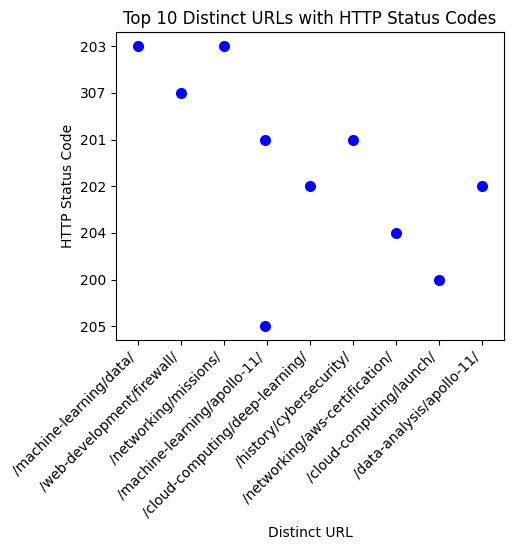

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming top_10_results contains the top 10 distinct URLs with HTTP status codes
data = pd.DataFrame(top_10_results, columns=['Distinct URL', 'HTTP Status Code'])

# Create a strip plot using Seaborn for better aesthetics
plt.figure(figsize=(5, 4))  # Adjust the figure size if needed
sns.stripplot(data=data, x='Distinct URL', y='HTTP Status Code', color='blue', jitter=True, size=8)
plt.title('Top 10 Distinct URLs with HTTP Status Codes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()



In [ ]:
# analysis 1 and result using RDD operators:

#Filtered the logs with some conditions
filter_method_with_url = log_rdd.filter(lambda row: row["URL"] == "/history/missions/" and row["HTTPMethod"] == "POST")

#count the filtered logs
count = filter_method_with_url.count()
print(f"Number of records with the specified URL and the method post is: {count}")

#Listed the filtered ten records
sample_records = filter_method_with_url.take(10)
for record in sample_records:
    print(record)



Number of records with the specified URL and the method post is: 8442
Row(Host='88.211.105.115', Timestamp='04/Mar/2022:14:17:48', HTTPMethod='POST', URL='/history/missions/', HTTPVersion='HTTP/2.0', HTTPStatusCode='414', BytesInReply='12456', Message='Caution: System may require attention. Check logs for details.')
Row(Host='86.89.108.78', Timestamp='29/Jul/2023:01:54:34', HTTPMethod='POST', URL='/history/missions/', HTTPVersion='HTTP/2.0', HTTPStatusCode='201', BytesInReply='56356', Message='Potential issue detected. Please review and address.')
Row(Host='187.151.233.241', Timestamp='10/Jul/2023:06:41:54', HTTPMethod='POST', URL='/history/missions/', HTTPVersion='HTTPS/1.0', HTTPStatusCode='200', BytesInReply='20586', Message='Debug: Detailed system state information.')
Row(Host='198.217.192.154', Timestamp='26/Aug/2022:23:44:16', HTTPMethod='POST', URL='/history/missions/', HTTPVersion='HTTP/2.0', HTTPStatusCode='202', BytesInReply='8230', Message='Update: Routine status report. All

In [ ]:
# analysis 2 and result using RDD operators:

#Filter the logs with specific version
filter_rdd = log_rdd.filter(lambda row: row.HTTPVersion == "HTTP/2.0")

#mapping the url and bytes_in_reply
mapped_rdd = filter_rdd.map(lambda row: (row["URL"], int(row["BytesInReply"])))
print("Mapped RDD:")
print(mapped_rdd.take(10))

# calculated the sum of bytes in the reply for each unique URL
reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)
print("Reduced RDD:")
print(reduced_rdd.take(10))

#sorted the logs in descending order
sorted_rdd = reduced_rdd.sortBy(lambda x: x[1], ascending=False)
print("Sorted RDD:")
print(sorted_rdd.take(5))

#show top 20 url with maximum bytes_in_the_reply
result = sorted_rdd.take(20)

#find url with max_bytes
max_values = sorted_rdd.take(1)
max_url, max_bytes = max_values[0] if max_values else (None, None)

# find url with min_bytes
min_values = sorted_rdd.take(sorted_rdd.count())
min_url, min_bytes = min_values[-1] if min_values else (None, None)

# Print the results
print(f"URL with Maximum Bytes: {max_url}, Bytes: {max_bytes}")
print(f"URL with Minimum Bytes: {min_url}, Bytes: {min_bytes}")


Mapped RDD:
[('/history/missions/', 12456), ('/security/firewall/', 30374), ('/history/apollo/', 63819), ('/history/launch/', 84446), ('/web-development/data/', 37029), ('/security/deep-learning/', 1685), ('/images/frontend-frameworks-comparison/', 22650), ('/software/apollo-11/', 49029), ('/security/missions/', 83003), ('/machine-learning/missions/', 4996)]
Reduced RDD:
[('/history/apollo/', 427933027), ('/web-development/data/', 423734475), ('/security/deep-learning/', 417194479), ('/software/apollo-11/', 423499363), ('/security/aws-certification/', 429113661), ('/history/countdown/', 422545968), ('/data-analysis/data/', 420665850), ('/networking/frontend-frameworks-comparison/', 430522402), ('/data-analysis/frontend-frameworks-comparison/', 421616523), ('/data-analysis/apollo-11/', 422888776)]
Sorted RDD:
[('/security/technology/', 437092680), ('/shuttle/firewall/', 434972582), ('/history/data/', 433874993), ('/networking/frontend-frameworks-comparison/', 430522402), ('/web-developm

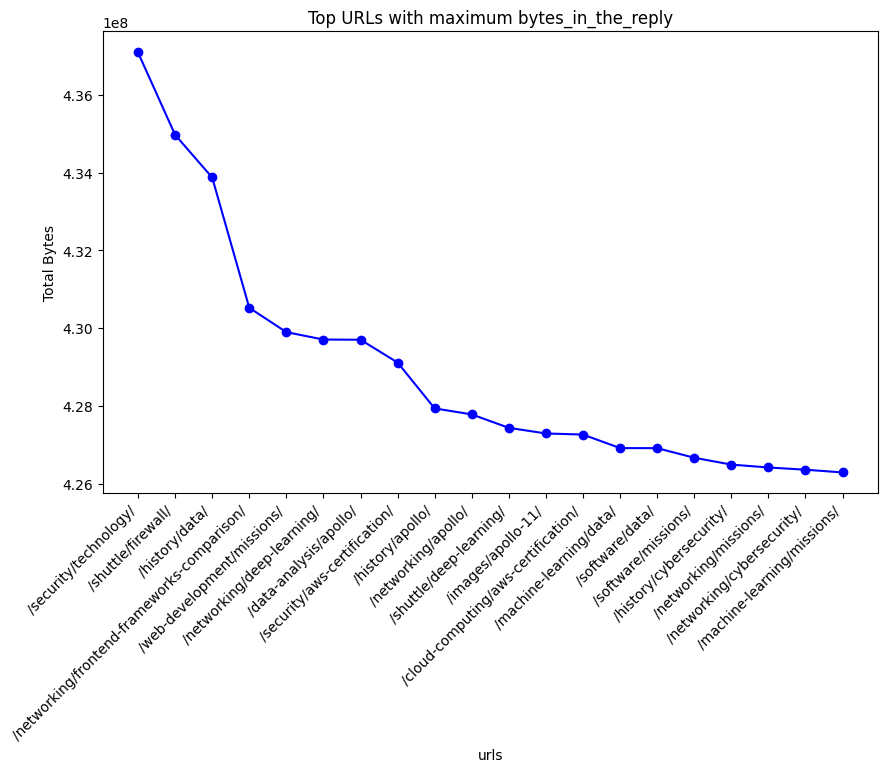

In [ ]:
#Extract URLs and total_bytes from the result
urls = [URL for (URL, BytesInReply) in result]
total_bytes = [BytesInReply for (URL, BytesInReply) in result]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(urls, total_bytes, marker='o', linestyle='-', color='b')
plt.xlabel('urls')
plt.ylabel('Total Bytes')
plt.title('Top URLs with maximum bytes_in_the_reply')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# analysis 3 and result using RDD operators:

#Filter the logs with warning unusual behaviour message in year of 2022
#sort logs with timestamp in descending order
filtered_and_sorted_logs = (
    log_rdd
    .filter(lambda log: "Warning: Unusual behavior detected. Investigate further." in log["Message"] and datetime.strptime(log["Timestamp"], "%d/%b/%Y:%H:%M:%S").year == 2022)
    .sortBy(lambda log: datetime.strptime(log["Timestamp"], "%d/%b/%Y:%H:%M:%S"), ascending=False)
)

#find total_logs and latest_timestamp
total_logs = filtered_and_sorted_logs.count()
latest_timestamp = filtered_and_sorted_logs.first()["Timestamp"]
print(f"Total Logs: {total_logs}")
print(f"Latest Timestamp: {latest_timestamp}")

#Collected the representing HTTP status codes and their respective counts
aggregated_status_codes = (
    filtered_and_sorted_logs
    .map(lambda log: (log["HTTPStatusCode"], 1))  # Map to (status_code, 1)
    .reduceByKey(lambda x, y: x + y)  # Count logs for each status code
    .collect()
)
# Display the count of each unique HTTP status code
print("\n Display the count of each unique HTTP status code:")
for status_code, count in aggregated_status_codes:
    print(f"Status Code: {status_code}, Count: {count}")



Total Logs: 177981
Latest Timestamp: 31/Dec/2022:23:55:47

 Display the count of each unique HTTP status code:
Status Code: 414, Count: 12591
Status Code: 202, Count: 12649
Status Code: 304, Count: 12696
Status Code: 307, Count: 12638
Status Code: 308, Count: 12579
Status Code: 200, Count: 12780
Status Code: 204, Count: 12619
Status Code: 201, Count: 12929
Status Code: 415, Count: 12655
Status Code: 404, Count: 12710
Status Code: 416, Count: 12734
Status Code: 500, Count: 12934
Status Code: 205, Count: 12742
Status Code: 203, Count: 12725


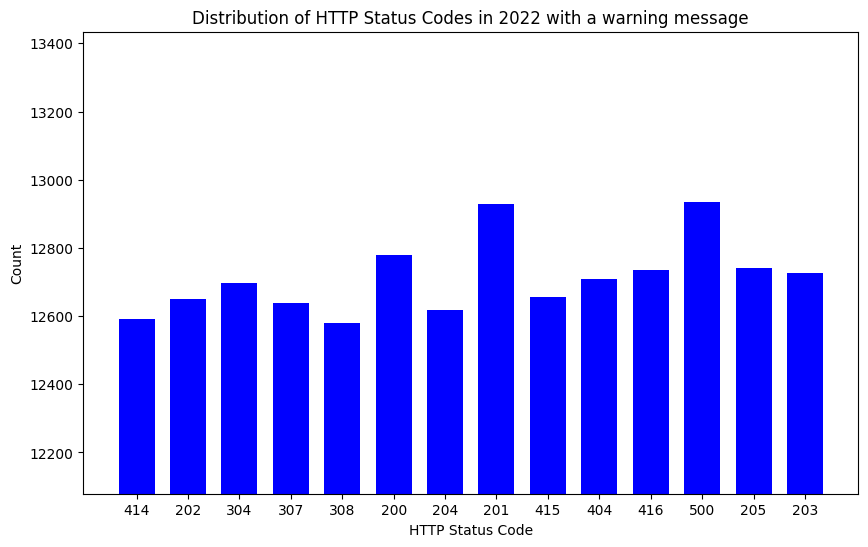

In [ ]:
#data visualisation using MatPlotLib
status_codes, counts = zip(*aggregated_status_codes)

#draw a figure using subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the width to create separation between bars
bar_width = 0.7

# Plotting bars
ax.bar(status_codes, counts, width=bar_width, color='blue')

# Customize the y-axis limits based on the range of counts
ax.set_ylim(min(counts) - 500, max(counts) + 500)

# Customize the plot
ax.set_xlabel('HTTP Status Code')
ax.set_ylabel('Count')
ax.set_title('Distribution of HTTP Status Codes in 2022 with a warning message')
plt.show()


In [ ]:
# analysis 1 and result using RDD operators:

# Finding records with status code 500 and find the mean for status code 500.
# Define a regular expression pattern to extract status code
import re
status_pattern = r'"\s(\d+)\s'
# Function to extract status code
def extract_status_code(line):
    match = re.search(status_pattern, line)
    if match:
        return int(match.group(1))
    else:
        return None
#Find the total lines count
total_lines_count = log_rdd.count()

# Filter lines with status code as 500 and Count lines with status code 500.
lines_count_with_500_status = log_rdd.filter(lambda line: extract_status_code(line) == 500)\
                        .map(lambda line: extract_status_code(line)) \
                        .count()
# Calculate the mean of the status code 500
mean_status_500 = lines_count_with_500_status/total_lines_count
# Print the mean status code 500
print(mean_status_500)


0.071509


In [ ]:
# analysis 2 and result using RDD operators:

import re
status_message_pattern = r'"\s(\d+)\s(\d+)\s(.*)$'

# Function to extract status code and message using regex
def extract_status_message(line):
    match = re.search(status_message_pattern, line)
    if match:
        return ((match.group(1), match.group(3)), 1)  # Return a tuple with a count of 1 for each pair
    return None

# Apply the function to extract status code and message from the RDD and count occurrences
status_message_count_rdd = log_rdd.map(extract_status_message)\
                                  .filter(lambda x: x is not None) \
                                  .reduceByKey(lambda x, y: x + y)
# Collecting and printing the count of extracted status code and message
extracted_status_message_count = status_message_count_rdd.collect()
for ((status, message), count) in extracted_status_message_count:
    if status and message:
        print(f"Status Code: {status}, Message: {message}, Count: {count}")

Status Code: 500, Message: Debug: Detailed system state information., Count: 23931
Status Code: 415, Message: FYI: System operating within normal parameters., Count: 23842
Status Code: 307, Message: Informational message. No action required., Count: 23482
Status Code: 204, Message: FYI: System operating within normal parameters., Count: 23686
Status Code: 201, Message: Potential issue detected. Please review and address., Count: 24034
Status Code: 202, Message: Warning: Unusual behavior detected. Investigate further., Count: 23700
Status Code: 304, Message: FYI: System operating within normal parameters., Count: 23647
Status Code: 308, Message: Informational message. No action required., Count: 23658
Status Code: 307, Message: Caution: System may require attention. Check logs for details., Count: 23772
Status Code: 201, Message: Informational message. No action required., Count: 23689
Status Code: 304, Message: Debugging information. For developer reference only., Count: 23487
Status C

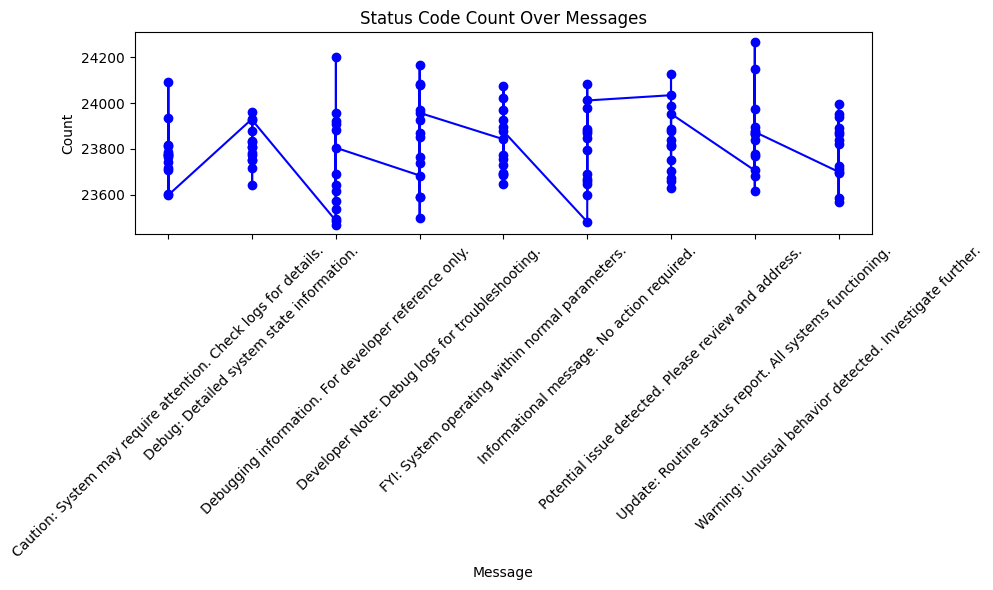

In [ ]:
# analysis 2 graph
import matplotlib.pyplot as plt
# Sorting the RDD data by message for a line plot
sorted_data = status_message_count_rdd.map(lambda x: (x[0][1], x[1])).sortByKey().collect()
messages, counts = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(messages, counts, marker='o', linestyle='-', color='b')
plt.title('Status Code Count Over Messages')
plt.xlabel('Message')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# analysis 3 and result using RDD operators:

#To display insight about no of service hits.
#Example line '94.79.228.218 - - [05/May/2023:13:37:41] "PUT /machine-learning/frontend-frameworks-comparison/ HTTP/2.0" 201 12453 Potential issue detected. Please review and address.'

# Define the regular expression pattern to capture the URL
import re
url_pattern = r'"\w+ ([^ ]+) HTTP'
# Function to extract the URL using regex
def extract_url(line):
    match = re.search(url_pattern, line)
    if match:
        return match.group(1)
    return None

# Define the regular expression pattern to capture the first and second parts
pattern = r'^/([^/]+)/([^/]+)/$'
# Function to extract first using regex
def extract_parts(url):
    match = re.search(pattern, url)
    if match:
        return match.group(1)  # Returns the first
    return None
# Extract URL firstpart from log lines using regex
# Applying the function to the RDD
firstPart_urls_rdd = log_rdd.map(extract_url)\
                      .map(extract_parts) \
                      .map(lambda firstPart: (firstPart,1))
#Based on firstPart of url, count the number of hits to web server.
firstPart_urls_count = firstPart_urls_rdd.reduceByKey(lambda x,y: x+y)
# Collecting the extracted URLs
firstPart_urls_count.collect()

[('shuttle', 299611),
 ('security', 299997),
 ('networking', 300534),
 ('cloud-computing', 299690),
 ('history', 300732),
 ('images', 299249),
 ('machine-learning', 299126),
 ('software', 300815),
 ('web-development', 299691),
 ('data-analysis', 300555)]

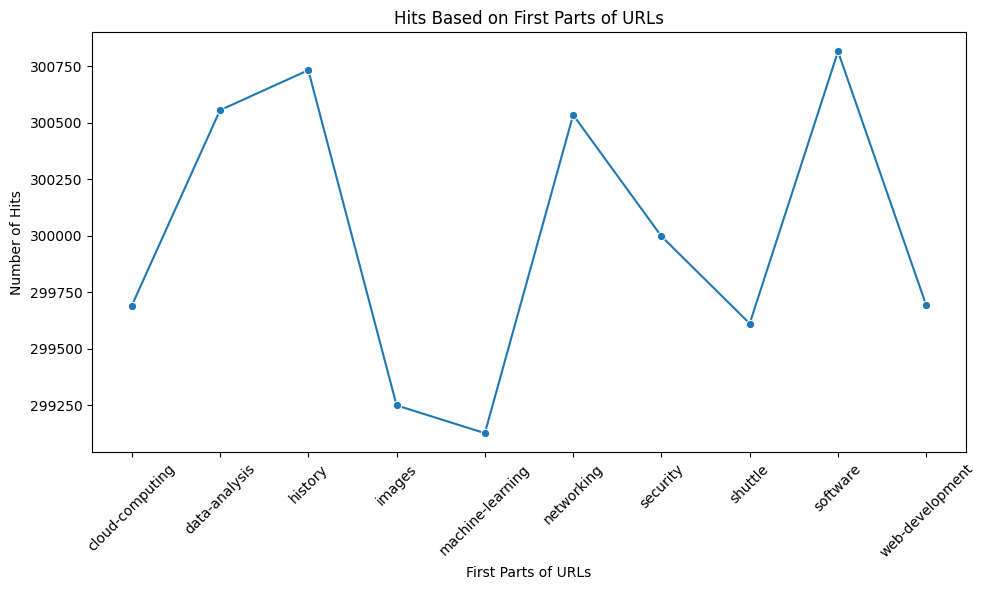

In [ ]:
# analysis 3: Graph
import seaborn as sns
import matplotlib.pyplot as plt

# Collecting the data from RDD
data = firstPart_urls_count.collect()

# Creating a DataFrame from the collected data
import pandas as pd
df = pd.DataFrame(data, columns=['FirstPart', 'Count'])
# Sorting the DataFrame by count values
df = df.sort_values('FirstPart')
# Plotting with Seaborn as a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='FirstPart', y='Count', data=df, marker='o')
plt.xlabel('First Parts of URLs')
plt.ylabel('Number of Hits')
plt.title('Hits Based on First Parts of URLs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **LSEP (legal, social, ethical, and professional)**


For all analyses performed, critically analyze the legal, social, ethical, and professional implications associated with the data and the analysis. Consider factors such as `data privacy`,` data protection`, `bias`, `fairness`, `transparency`, and the `potential impact` of the analysis on individuals or society as a whole.



## Legal

The legal ramifications associated with data analysis necessitate strict adherence to regulations about the privacy and safeguarding of data, which may vary depending on jurisdiction. It is mandatory to obtain consent before collecting and analyzing user data as per legal requirements, failure of which could lead to potential legal action and penalties. The extraction and examination of log data give rise to concerns regarding individual privacy, thereby demanding meticulous compliance with regulations governing the protection of information.Maintaining compliance with regulations like the General Data Protection Regulation (GDPR) and the Health Insurance Portability and Accountability Act (HIPAA) are essential for securing the privacy of individuals concerning their data and averting legal action.

## Professional

Maintaining professional integrity remains paramount when it comes to conducting accurate and reliable analyses. It becomes imperative for analysts not only to identify but also communicate any limitations inherent within both the dataset being employed for analysis as well as the techniques utilized during this process. Adhering strictly to professional standards mandates presenting findings objectively irrespective of whether they align or diverge from preconceived notions or hypotheses. Transparency throughout each stage encompassed within analytical procedures along with clear articulation of results are pivotal considerations essential within a professional setting. By upholding professional integrity at all times, analysts ensure ethical practice while adhering steadfastly to supreme levels of competence expected within their field.

## Ethical

The ethical considerations of data and analysis are the most significant features of data management. To stop unauthorized people from accessing private information, it's necessary to maintain data protection and privacy. Whenever biased datasets or algorithms are trained on unsuitable or biased data, they may yield results that are unequal. For example, an algorithm trained on biased hiring data can show group bias, creating injustice. People have the ability to know how their data is used and to decide for themselves whether or not to release it, thanks to the transparency element. Finally, because the analysis may have large impacts, it is necessary to take into consideration how it may affect specific people or society at large.

## Social
Societal Implications When working with data, it is crucial to be mindful of the unintended consequences that may arise from uncovering patterns in requests. It can inadvertently expose vulnerabilities and compromise security. Therefore, it becomes essential to prioritize responsible disclosure of any findings and collaborate with relevant stakeholders to address potential security concerns. Another crucial aspect when analyzing data is addressing bias and promoting fairness from a societal perspective. Biased analyses have the potential to perpetuate inequalities by disproportionately affecting different demographic groups. It allows us to build trust within the user community by providing clear insights into how data is analyzed and utilized. Through this transparency, we establish accountability among analysts while fostering social responsibility towards our actions.



# **Convert ipynb to HTML**

---



In [ ]:
# install nbconvert
!pip3 install nbconvert


# convert ipynb to html
# file name: "Your_Group_ID_CN7031.ipynb
!jupyter nbconvert --to html 76_CN7031.ipynb

[NbConvertApp] WARNING | pattern '76_CN7031.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    E

In [ ]:
!ls /content


sample_data
